In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
sns.set()

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/shprjct/age_gender.csv')

In [ ]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df,
                 batch_size = 32,
                 input_size=(48, 48, 3),
                 shuffle=True,
                 data_augmentation = False):
        self.df = df
        self.batch_size = batch_size
        self.input_size = input_size
        self.data_augmentation = data_augmentation
        self.var = 1
        
        self.imageGenerator = ImageDataGenerator(
            horizontal_flip = True,
            #vertical_flip = True,
            fill_mode = 'nearest',
            zoom_range = (1, 1.1),
            width_shift_range = 0.1,
            height_shift_range = 0.1,
            rotation_range = 10
        )
        
        self.images = []
        self.age_labels = []        
        self.ethnicity_labels = []
        self.gender_labels = []
        
        for index, row in tqdm(df.iterrows()):
            image = np.fromstring(row['pixels'], sep = ' ', dtype = np.uint8).reshape((48,48))
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            
            self.images.append(image)
            
            self.age_labels.append(row['age'])
            self.ethnicity_labels.append(row['ethnicity'])
            self.gender_labels.append(row['gender'])
            
            
        self.images = np.array(self.images)
        self.age_labels = np.array(self.age_labels).astype(np.float32)
        self.ethnicity_labels = np.array(self.ethnicity_labels).astype(np.float32)
        self.gender_labels = np.array(self.gender_labels).astype(np.float32)
        
        p = np.random.permutation(len(self.age_labels))
        self.images = self.images[p]
        self.age_labels = self.age_labels[p]
        self.ethnicity_labels = to_categorical(self.ethnicity_labels[p], num_classes=5)
        self.gender_labels = self.gender_labels[p]
        
        self.n = len(self.df)
        
    
    def __getitem__(self, index):
        images = []
        
        for i in range(self.batch_size):
            image = self.images[index * self.batch_size + i]
            
            if self.data_augmentation:                
                image = self.imageGenerator.random_transform(image)
                
            images.append(image)
            
        s = slice(self.batch_size * index, (index + 1) * self.batch_size)
        return np.array(images), (self.age_labels[s], self.ethnicity_labels[s], self.gender_labels[s])
    
    def __len__(self):
            
        return self.n // self.batch_size
    
    def on_epoch_end(self):
        
        #Random permutation
        p = np.random.permutation(len(self.age_labels))
        self.images = self.images[p]
        self.age_labels = self.age_labels[p]
        self.ethnicity_labels = self.ethnicity_labels[p]
        self.gender_labels = self.gender_labels[p]

In [ ]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


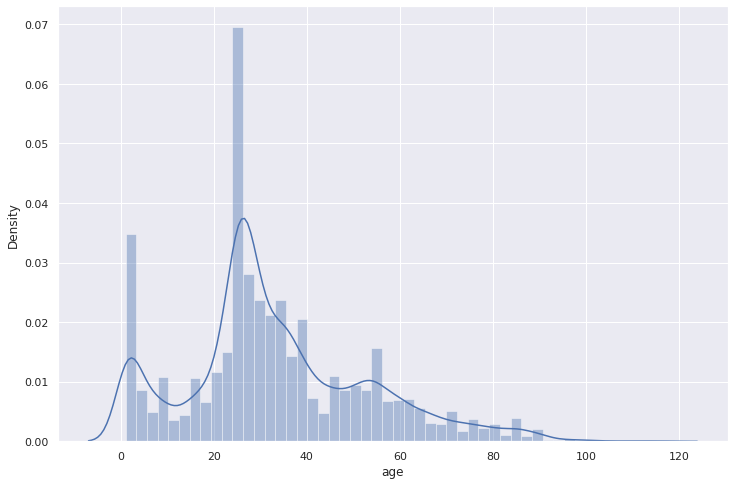

In [ ]:
plt.figure(figsize=(12,8))
sns.distplot(df['age']);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


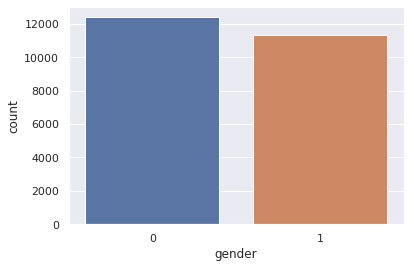

In [ ]:
sns.countplot(df['gender']);

In [ ]:
df['pixels'] = df['pixels'].map(lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48, 48))

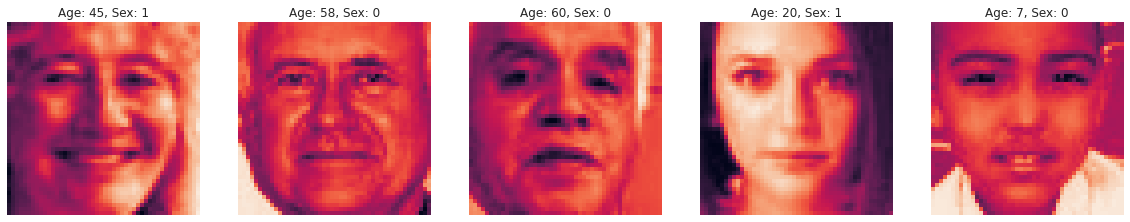

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    random_face = np.random.choice(len(df))
    
    age = df['age'][random_face]
    #ethnicity = df['ethnicity'][random_face]
    gender = df['gender'][random_face]
    
    axes[i].set_title('Age: {0}, Sex: {1}'.format(age, gender))
    axes[i].imshow(df['pixels'][random_face])
    axes[i].axis('off')

In [ ]:
X = np.array(df['pixels'].to_list())
X_reshaped = X.reshape(X.shape[0],48,48,1)


In [ ]:
if np.max(X_reshaped) > 1: X_reshaped = X_reshaped /255

In [ ]:
input_shape = X_reshaped.shape[1:] 

In [ ]:
y = df['age'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [ ]:
age_model = Sequential()

age_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(BatchNormalization())

age_model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.3))
age_model.add(BatchNormalization())

age_model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.3))
age_model.add(BatchNormalization())

age_model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.5))
age_model.add(BatchNormalization())

age_model.add(Flatten())
age_model.add(Dense(128, activation='relu'))
age_model.add(Dropout(0.4))
age_model.add(Dense(1))


In [ ]:
age_model.compile(optimizer='adam', loss='mse')

In [ ]:
n_epochs = 50
batch_size=64

In [ ]:
callbacks = [EarlyStopping(patience=4, monitor='val_loss', mode='min'), 
             ReduceLROnPlateau(patience=2, verbose=1)]

In [ ]:
history = age_model.fit(X_train, y_train, 
                           epochs=n_epochs,
                           batch_size=batch_size,
                           callbacks=callbacks,
                           validation_data=(X_test, y_test))

Epoch 1/50
297/297 [==============================] - 30s 53ms/step - loss: 228.5490 - val_loss: 3402.0564 - lr: 0.0010
Epoch 2/50
297/297 [==============================] - 15s 49ms/step - loss: 139.0259 - val_loss: 536.4144 - lr: 0.0010
Epoch 3/50
297/297 [==============================] - 15s 49ms/step - loss: 118.5313 - val_loss: 133.0802 - lr: 0.0010
Epoch 4/50
297/297 [==============================] - 15s 50ms/step - loss: 109.2675 - val_loss: 101.3812 - lr: 0.0010
Epoch 5/50
297/297 [==============================] - 15s 49ms/step - loss: 101.9180 - val_loss: 645.2595 - lr: 0.0010
Epoch 6/50
296/297 [============================>.] - ETA: 0s - loss: 93.4467
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
297/297 [==============================] - 14s 49ms/step - loss: 93.4897 - val_loss: 154.6314 - lr: 0.0010
Epoch 7/50
297/297 [==============================] - 14s 49ms/step - loss: 80.0574 - val_loss: 72.7521 - lr: 1.0000e-04
Epoch 8/50
297/297 [=

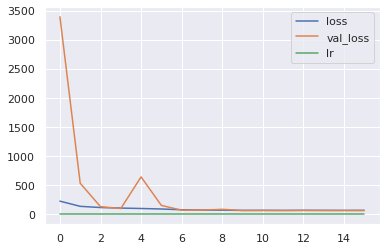

In [ ]:
pd.DataFrame(history.history).plot();

In [ ]:
valid_score = age_model.evaluate(X_test, y_test, verbose=1)

149/149 [==============================] - 2s 10ms/step - loss: 67.8471


In [ ]:
y_pred = age_model.predict(X_test)

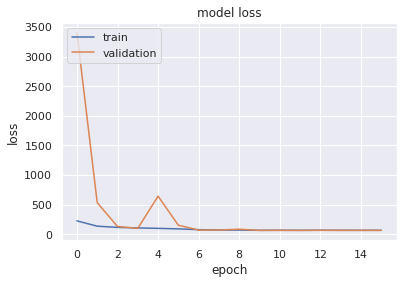

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))

MAE: 5.946505042451063


In [ ]:
y = df['gender'].values
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [ ]:
gender_model = Sequential()

gender_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(BatchNormalization())

gender_model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Dropout(0.4))
gender_model.add(BatchNormalization())

gender_model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Dropout(0.5))
gender_model.add(BatchNormalization())

gender_model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Dropout(0.5))
gender_model.add(BatchNormalization())

gender_model.add(Flatten())
gender_model.add(Dense(64, activation='relu'))
gender_model.add(Dropout(0.4))

gender_model.add(Dense(1, activation='sigmoid')) #For binary classification activation function is sigmoid 

gender_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #...and loss function is binary_crossentropy

gender_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 23, 23, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 23, 23, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 11, 11, 128)      0         
 2D)                                                             
                                                      

In [ ]:
callbacks = [EarlyStopping(patience=4, monitor='val_accuracy', mode='max'), 
              ReduceLROnPlateau(patience=2, verbose=1)]

In [ ]:
history = gender_model.fit(X_train, y_train, 
                           epochs=n_epochs,
                           batch_size=batch_size,
                           callbacks=callbacks,
                           validation_data=(X_test, y_test))

Epoch 1/50
297/297 [==============================] - 17s 51ms/step - loss: 0.5646 - accuracy: 0.7253 - val_loss: 0.9918 - val_accuracy: 0.5206 - lr: 0.0010
Epoch 2/50
297/297 [==============================] - 15s 49ms/step - loss: 0.3828 - accuracy: 0.8264 - val_loss: 0.3514 - val_accuracy: 0.8365 - lr: 0.0010
Epoch 3/50
297/297 [==============================] - 15s 50ms/step - loss: 0.3339 - accuracy: 0.8515 - val_loss: 0.3009 - val_accuracy: 0.8578 - lr: 0.0010
Epoch 4/50
297/297 [==============================] - 14s 49ms/step - loss: 0.3055 - accuracy: 0.8640 - val_loss: 0.4310 - val_accuracy: 0.8040 - lr: 0.0010
Epoch 5/50
297/297 [==============================] - 15s 50ms/step - loss: 0.2850 - accuracy: 0.8740 - val_loss: 0.2845 - val_accuracy: 0.8781 - lr: 0.0010
Epoch 6/50
297/297 [==============================] - 15s 49ms/step - loss: 0.2697 - accuracy: 0.8835 - val_loss: 0.2502 - val_accuracy: 0.8956 - lr: 0.0010
Epoch 7/50
297/297 [==============================] - 15s 

In [ ]:
valid_score = gender_model.evaluate(X_test, y_test, verbose=1)
print('Accuracy for test set: {0}'.format(valid_score[1]))

149/149 [==============================] - 2s 10ms/step - loss: 0.2285 - accuracy: 0.9139
Accuracy for test set: 0.9139422178268433


In [ ]:
y_pred = gender_model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2468
           1       0.91      0.91      0.91      2273

    accuracy                           0.91      4741
   macro avg       0.91      0.91      0.91      4741
weighted avg       0.91      0.91      0.91      4741



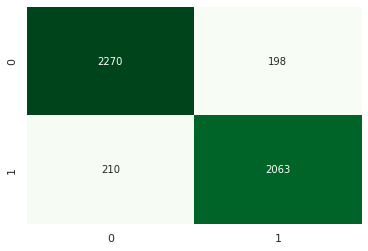

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Greens', cbar=False, annot=True, fmt='d');


In [ ]:
y_pred = y_pred.reshape(y_pred.shape[0])

In [ ]:
y = df['ethnicity'].values

y = to_categorical(y, 5)
y

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
  y_pred = age_model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2468
           1       0.40      0.02      0.04      2273
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

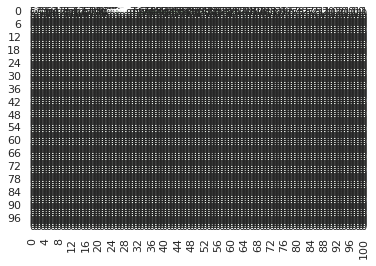

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Greens', cbar=False, annot=True, fmt='d');
